In [26]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
# import installed packages
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.tsa.seasonal import STL
# import functions from custom modules
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *
from simulation_tools import *

# Generate simulated 10 day dataset from Zinser et al experimental data
1. Combine Hourly Qc data, PAR, gross 14C fixation, carbon loss into one dataset. 
>a) Calculate net carbon fixation from gross fixation and carbon loss
2. Repeat days from original dataset 5x to get 10 day simulated dataset.
3. Randomly remove data of certain percentages.
4. Run iterative interpolation to impute new values. 
5. Compare imputed values against original values to calculate error (RMSE).
6. Block bootstrap to get uncertainites for productivity measurements.

### Calculating hourly Qc from FCM and combining with measurements data
Returns single dataframe with all necessary data for analysis: `pro_data`

In [2]:
# read in flow cytometry data
culture_data=pd.read_csv('simulation_data/zinser_figure2a.csv')
psd_data=pd.read_csv('simulation_data/zinser_psd.csv')

#### reformat to calculate hourly average Qc ####
# get experimental time from culture dataset
X = list(culture_data['exper time'])
# get size classes from psd data columns
Y = list(psd_data.columns[1:].astype(float))
# get particle size distrubition data from dataframe
Z = psd_data.iloc[:,1:].T.to_numpy()

# make new dataframe with particle size distribution data and reset the index
df = pd.DataFrame(data=Z, columns=X, index=Y).reset_index()
# rename column to size_bin
df.rename(columns={'index':'size_bin'},inplace=True)
# reformat data from wide to long
df_long=pd.melt(df, id_vars=['size_bin'], var_name='hour', value_name='abundance')
# calculate sum of each size bin using size and abundance
df_long['Qc_sum'] = df_long['size_bin'] * df_long['abundance']
# filter out size classes with no abundance
df_long = df_long[df_long.abundance > 0]

# group by cruise and date to get n and summed qc by the hour
df_group = df_long.groupby(['hour']).sum().reset_index()
# get mean Qc per hour and convert Qc from fg -> pg
df_group['Qc_hour'] = (df_group['Qc_sum']/df_group['abundance'])/1000
# subset just the columns we care about
pro_data = df_group[['hour','Qc_hour']]

#### Add in PAR and measurements data ####
# get PAR data
ds = xr.open_dataset('simulation_data/zinser_processed.nc',
                    decode_times=False)
pro_data['par']=ds.PAR.values
# get c-fixation and loss data
gt = xr.open_dataset('simulation_data/zinser_ground_truth.nc',
                    decode_times=False)
# get carbon fixation for all rows in pg
pro_data['GPP']=gt.carbonfix.values/1000
# get carbon loss for all rows except last in pg
pro_data.loc[0:23,'carbonloss']=gt.carbonloss.values/1000
# add net c-fiszation for all rows
pro_data['NPP'] = pro_data['GPP']-pro_data['carbonloss']

### Generate 10 day simulated dataset
Cuts off the last day to repeat to produce continuous transition into next simulated days

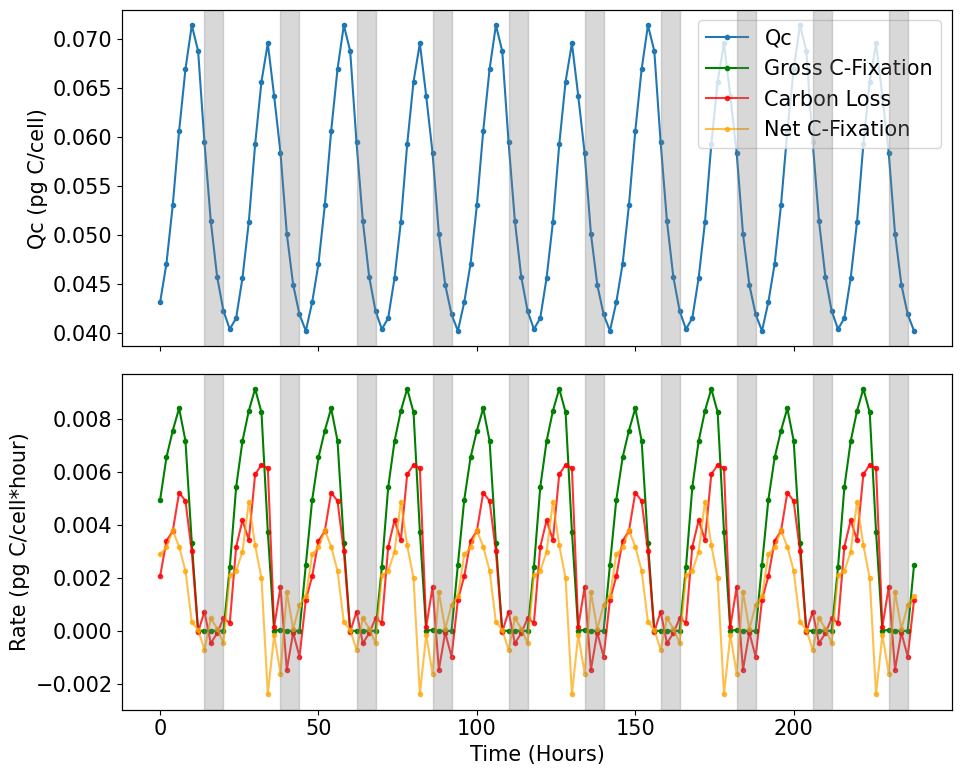

In [12]:
# create 10 day simulated data for Qc data
ten_days=generate_simulated(pro_data, 10)

#### Plot to check if simulation successful ####
plot_simulated_rates(ten_days)

### Randomly remove data 
Try with varying percentages of missing data

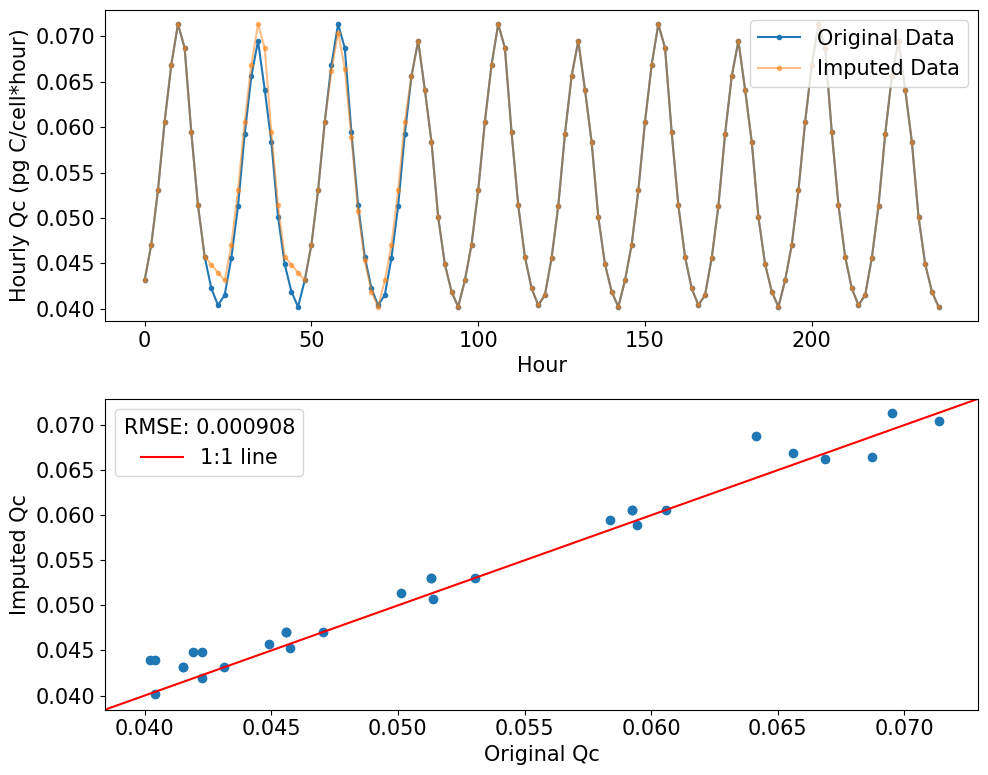

In [13]:
from sklearn.metrics import mean_squared_error
# generate missing data
# missing_25=generate_missing_data(ten_days, 0.25)
missing_25=generate_missing_chunks(ten_days, 30, 0.25, 'Qc_hour')
# calculate imputed values
impute_df=run_imputation(missing_25)

#### plot results ####
plot_imputed(impute_df)

### Calculate Imputation Error Metrics
Percent Bias (PB), Coverage Rate (CR), and Average Width (AW) ([Reference](https://stefvanbuuren.name/fimd/sec-evaluation.html))
- Percent Bias is calculated by taking the average of (actual - predicted) / abs(actual) across all observations. ([reference](https://rdrr.io/cran/Metrics/man/percent_bias.html#:~:text=Percent%20Bias%20is%20calculated%20by,(actual)%20across%20all%20observations.)
- Coverage rate/probability is calculated by the number of true values that fall within the CI (here I use 95% but not sure if too wide/narrow). We can simulate many runs to get an average lower/upper q, then check each true value against the CI range. 

In [14]:
# # store data here
# dfs=[]
# # calculate qs
# low_q=[]
# up_q=[]
# # simulate runs
# for n in range(0,100):
#     missing_25=generate_missing_chunks(ten_days, 30, 0.25)
#     # calculate imputed values
#     impute_df=run_imputation(missing_25)
#     # store vals
#     dfs.append(impute_df)
#     low_q.append(lower_q(impute_df['with_missing']))
#     up_q.append(upper_q(impute_df['with_missing']))
    
# ## helper function to calculate percent bias
# def calc_pb(df):
#     obs=df['Qc_hour']
#     pred=df['with_missing']
#     return np.mean((obs-pred)/np.abs(obs)) * 100


# sim_dfs=pd.concat(dfs)
# calc_pb(sim_dfs)
# # calculate mean CI
# mean_low, mean_up = np.mean(low_q), np.mean(up_q)
# # how many observed values fall within CI

### Calculate growth rates and productivity on imputed datasets
Compare against measurements to get error

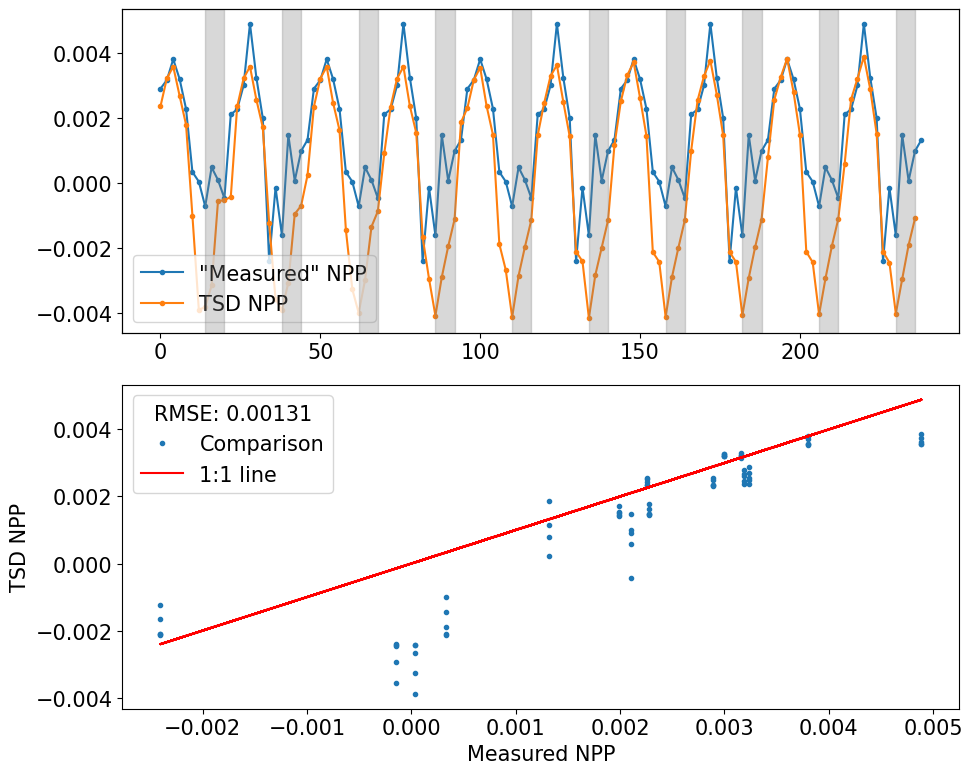

In [15]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')

# get tsd components
tsd_df=run_STL(impute_df, 'with_missing')
# calculate hourly growth by exponential growth and maintain correct order
tsd_df['hourly_growth']=exp_growth(tsd_df, 'diel',2).shift(-1)
# calculate hourly productivity
rates_df=calc_productivity(tsd_df,'hourly_growth','Qc_hour')

#### Plot results ####
fig,rmse=plot_productivity(tsd_df)

### Create baseline
Calculate growth rate and productivity without decomposition

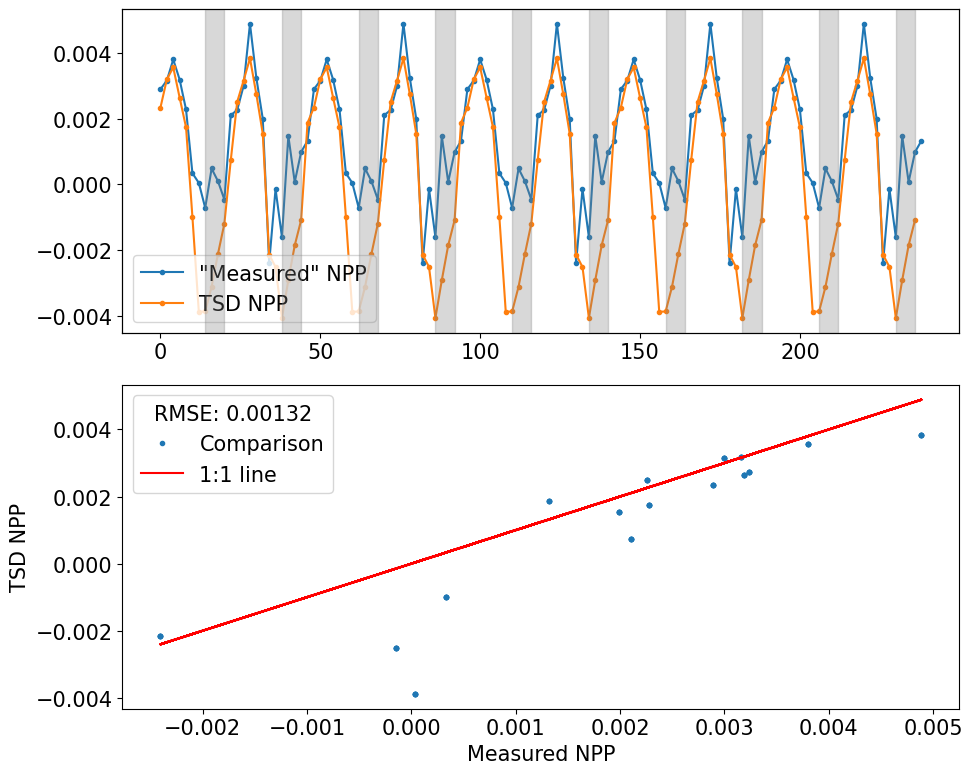

In [16]:
## generate simulated data
base_growth=exp_growth(ten_days,'Qc_hour',2).shift(-1)
# add to data
baseline=ten_days.copy()
baseline['hourly_growth']=base_growth
baseline=calc_productivity(baseline, 'hourly_growth','Qc_hour')
# plot
fig,rmse=plot_productivity(baseline)

### Run moving block bootstrapping (MBB) on models to get uncertainty values

1. Get residual values
2. Separate residuals into _l_ length blocks
3. Randomly draw with resampling to create new time series of residuals
4. Combine with seasonal and trend components to generate new synthetic time series
5. Calculate new productivity values from synthetic time series
6. Repeat **_n_** times to get distribution of error

#### References
- Medium [guide](https://medium.com/@daydreamersjp/bootstrapping-on-time-series-data-moving-block-bootstrap-79aaf6648aec)
- Bergmeier et al. [slides](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cbergmeir.com/talks/bergmeir2014ISF_slides.pdf)
- Medium [tutorial (with paywall)](https://archive.ph/LSshc)


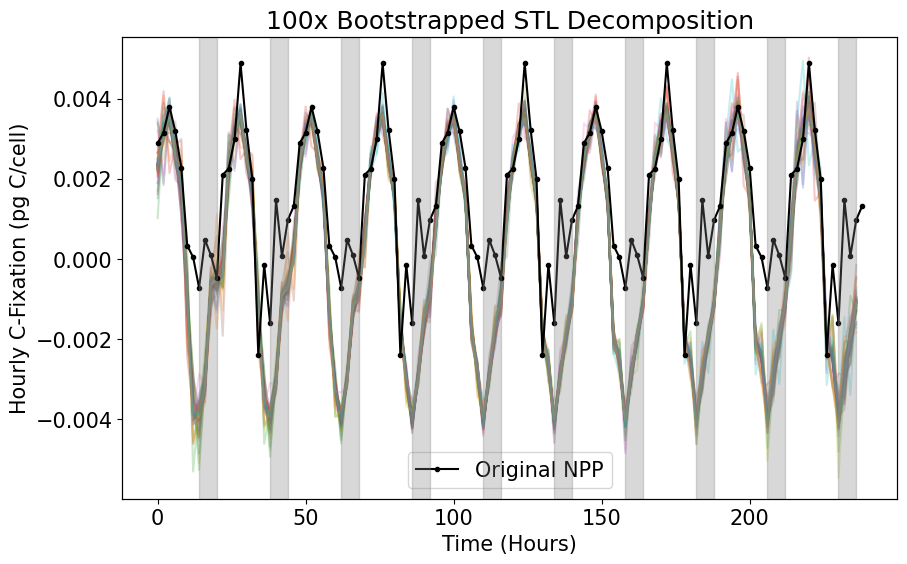

In [17]:
# run bootstrapping to get list of new dataframes
runs=100
mbb_df, mbb_data=run_bootstrapping(tsd_df, model='STL',runs=runs)
plot_bootstrapping(mbb_df, mbb_data, runs)

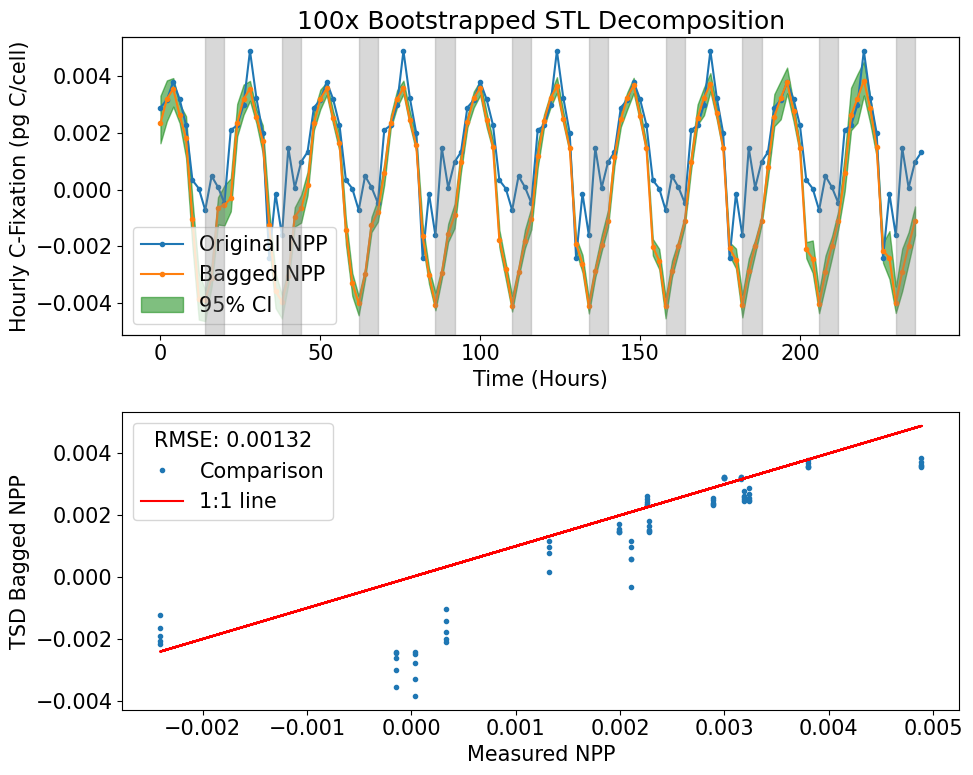

In [18]:
# perform bagging on bootstrapped data
bagged=bagging_results(mbb_data)

## plot results
fig,rmse=plot_bagging(bagged, model='STL')

### Put it all together and test for amount of data removed
Uncomment cell below to rerun, but this takes about ~15 minutes to complete. Alternatively, run the preloaded pickle file to check previous results 

- This cell runs bagged model 100x to collect aggregated error (RMSE, sMAPE, and mase)  in this case. 

In [19]:
## helper function to convert results to a dataframe
def to_df(dist,cols, error):
    df=pd.DataFrame(dist)
    df.columns=cols
    return(df.melt(var_name='removed', value_name=error))

## helper function to plot boxplot of errors
import seaborn as sns
def error_boxplot(df, error, model):
    fig,axs=plt.subplots(figsize=(10,6))
    sns.boxplot(data=df, x='removed',y=error, palette=sns.color_palette("viridis"))
    axs.set_xlabel('Proportion of Data removed (%)')
    axs.set_ylabel(error)
    axs.set_title(f'%Data Removed vs. Error: {model}')
    plt.show()
    
## helper function to plot grouped boxplot of errors
import seaborn as sns
def grouped_error_boxplot(df, error, model):
    fig,axs=plt.subplots(figsize=(10,6))
    sns.boxplot(x="remove", y=error,
        hue="block",
        data=df)
    if error.lower().startswith('r'):
        axs.set_ylim(0.001,0.0028)
    else:
        axs.set_ylim(1.0,2.5)
    axs.set_xlabel('Proportion of Data removed (%)')
    axs.set_ylabel(error)
    axs.set_title(f'%Data Removed vs. Error: {model}')
    plt.show()
    
## helper function to run model simulations
# input: pro_data=dataframe of original zinser dataset, data_len=integer specifying number of days to replicate,
# model = string representing model type (must be 'STL', 'baseline', or 'rolling'),
# model_runs = int for simulations to run, save_data=boolean to save data in files 
def run_model_simulations(pro_data, data_len, model, show_plots=True, model_runs=100, save_data=True):
    # list of data percentages to remove
    to_remove=[0, 0.1, 0.25, 0.4, 0.5, 0.6]
    # save error metrics distribution
    rmse_dist=[]
    mase_dist=[]
    # run model 100 times to collect error distributions
    for i in range(0,model_runs):
        # save rmses in each proportion
        print(i)
        rmses=[]
        smapes=[]
        mases=[]
        # run model for several iterations
        for prop in to_remove:
            # run model
            rmse, smape, mase=run_full_model(pro_data, data_len, prop, 
                                             model=model, runs=model_runs, show_plots=show_plots)
            print(f'data removed: {prop}, RMSE: {rmse}, MASE: {mase}')
            # save errors
            rmses.append(rmse)
            smapes.append(smape)
            mases.append(mase)
        # save list of rmses
        rmse_dist.append(rmses)
        mase_dist.append(mases)
    if save_data:
        ## Save files
        print('saving dfs...')
        to_df(rmse_dist, to_remove, 'RMSE').to_pickle(f'simulation_data/{model}_rmse_df')
        to_df(mase_dist, to_remove, 'MASE').to_pickle(f'simulation_data/{model}_mase_df')
    # return error distributions as dataframes
    return(to_df(rmse_dist, to_remove, 'rmse'), to_df(mase_dist, to_remove, 'mase'))



## heler function to run block missing data
# input: remove=float for proportion of data to remove
def block_run(data, days, remove, model):
    # list of data blokcs to remove 
    block_lens=[3,5,12,24,48,72]
    row_list=[]
    for block in block_lens:
        # check if chunk proportions exceeds data length
        if (len(data)*days)*remove < block:
            continue
        # else run model
        rmse, smape, mase=run_full_model(data, days, remove, 
                                         blocks=True, block_len=block, model=model, runs=100)
        # save rows
        row = {'model':model,'remove':remove, 'block':block, 'rmse':rmse, 'mase':mase}
        print(row)
        row_list.append(row)
    # return rows as df
    return(pd.DataFrame(row_list))


## helper function to run model simulations with block removed data
# input: pro_data=dataframe of original zinser dataset, data_len=integer specifying number of days to replicate,
# model = string representing model type (must be 'STL', 'baseline', or 'rolling'),
# model_runs = int for simulations to run, save_data=boolean to save data in files 
def run_block_model_simulations(pro_data, data_len, model, show_plots=True, model_runs=100, save_data=False):
    # list of data percentages to remove
    to_remove=[0, 0.1, 0.25, 0.4, 0.5, 0.6]
    # save error metrics distribution
    error_dfs=[]
    # run model 100 times to collect error distributions
    for i in range(0,model_runs):
        # save rmses in each proportion
        print(i)
        runs=pd.DataFrame(columns=['model','remove','block','rmse','mase'])
        # run model for several iterations
        for prop in to_remove:
            # run blocks model
            block_df=block_run(pro_data, data_len, prop, model)
            # list of dicts to df
            runs=pd.concat([runs,block_df])
        # save df to list
        error_dfs.append(runs.reset_index(drop = True))
    if save_data:
        ## Save files
        print('saving dfs...')
        pd.concat(error_df).to_pickle(f'simulation_data/block_{model}_error')
    # return list of error dfs
    return(error_dfs)


## helper function to run model with noise
# input: data=df to run model on days=int for number of days to simulate,
# remove=float for proportion of data to remove, model=str for model name
def noise_run(data, days,remove,model):
    # list of data blokcs to remove 
    noise_percents=[0.05, 0.1, 0.25, 0.5, 0.75, 1]
    row_list=[]
    for noise in noise_percents:
        # run model
        rmse, smape, mase=run_full_model(data, 
                   days=days, 
                   remove=remove,
                   noise=noise, 
                                         
                  model=model)
        # save rows
        row = {'model':model,'remove':remove, 'noise':noise, 'rmse':rmse, 'mase':mase}
        print(row)
        row_list.append(row)
    # return rows as df
    return(pd.DataFrame(row_list))

## function to run model simulations with noise
# input: pro_data=df to run model on, data_len=int for number of days to simulate,
# model=str for model name, show_plots (deprecated), model_runs=# simulations to run, 
# save_data= boolean flag to save data to file
def run_noise_model_simulations(pro_data, data_len, model, show_plots=True, model_runs=100, save_data=False):
    # save data in df
    runs=pd.DataFrame(columns=['model','remove','noise','rmse','mase'])
    for i in range(0,model_runs):
        # save rmses in each proportion
        print(i)
        # run model for several iterations
        run=noise_run(pro_data, data_len, 0, model)
        # list of dicts to df
        runs=pd.concat([runs,run])
        # save df to list
    if save_data:
        runs.to_pickle(f'simulation_data/noise_{model}_error')
    return(runs.reset_index(drop = True))

In [ ]:
## run blocked simulations
models=['baseline','naive','rolling','stl']
model_errors=[]
## running all the models (this took all night :O)
for model in models:
    print(model)
    model_error=run_block_model_simulations(pro_data, 
                                            10, 
                                            model=model)
    model_errors.append(model_error)
    
models=['baseline','naive','rolling','stl']
# combine data and save
for model, name in zip(model_errors,models):
    pd.concat(model).to_pickle(f'simulation_data/block_{name}_error')
    
# readin in data    
block_base_err=pd.read_pickle('simulation_data/block_baseline_error')
block_naive_err=pd.read_pickle('simulation_data/block_naive_error')
block_roll_err=pd.read_pickle('simulation_data/block_rolling_error')
block_stl_err=pd.read_pickle('simulation_data/block_stl_error')  

# plot results
model_dfs=[block_base_err, block_naive_err, block_roll_err, block_stl_err]
models=['baseline','naive','rolling','stl']
for df, name in zip(model_dfs, models):
    grouped_error_boxplot(df, 'rmse', name)
    grouped_error_boxplot(df, 'mase', name)

## Trend experiments
- Which model does best with changing trends?
 - 4 different trends: 
 1. Linear increasing trend (10 days)
 2. Increasing (5 days) then decreasing trend (5 days) (10 days total)
 3. Linear increasing trend (20 days)
 4. Increasing (5 days 2x) then decreasing trend (5 days 2x) (20 days total)
- Which model does best with trend+missing data?
- Which model does best with trend+noise?
- Which model does best with trend+missing data+noise?

Adding a trend back to data:
1. Decompose to get different components (doesn't matter which TSD first since most split stationary data very similarily)
2. Calculate a new trend (can grab one from SeaFlow data)
3. Multiply new trend with diel and residual components to generate new synthetic times series

In [239]:
# generate some data
days=10

## trend 1 = simple linear function (keep data reasonable)
# linear by multiplying qc
trend1 = np.linspace(1, 1.4, days)
# trend 2 = trend 1 but up and down for 10 days total
up=np.linspace(1,1.4,int(days/2))
down=np.flip(up)
trend2=np.concatenate((up, down))
# trend 3 (20 days linear increase)
trend3 =np.linspace(1, 1.4, int(days*2))
# trend 4 (20 days of up and down)
trend4=np.concatenate((up, down, up, down))

In [195]:
# helper function to add a trend to data
def add_trend(df, trend):
    df=df.copy()
    # set experiment days
    df['experiment_day']=df['hour'] // 24
    days = int(len(df)/12)
    
    # multiply by trend -- this results in changing amplitude
    # in this dataset, 12 rows represent 24H
    # multiply trend by each day in row
    for day, new_trend in zip(range(0,days), trend):
        # subset by day and multiply diel and resid by new trend
        sub = df.loc[df['experiment_day']==day]
        df.loc[sub.index,'new_ts'] = new_trend * sub.Qc_hour
    return df

In [252]:
# trends 3 and 4 experiments (20 days long)
sim_df = generate_simulated(pro_data, 20)
x = sim_df.index

trend4_df=add_trend(sim_df, trend4)
rates_df, rmse, smape, mase=run_full_model(pro_data, 10, 0,add_trend=True, trend_df=trend4_df,
              noise=0, model='rolling')
mase

1.333083023350741

In [237]:

# rates_df, rmse, smape, mase=run_full_model(pro_data, 10, 0,add_trend=True, trend_df=trend3_df,
#               noise=0, model='naive')
# mase

In [201]:
trend2_df=add_trend(sim_df, trend2)
rates_df, rmse, smape, mase=run_full_model(pro_data, 10, 0,add_trend=True, trend_df=trend2_df,
              noise=0, model='naive')
mase

1.2084410484127144

In [193]:
trend1_df=add_trend(sim_df, trend1)
rates_df, rmse, smape, mase=run_full_model(pro_data, 10, 0,add_trend=True, trend_df=trend1_df,
              noise=0, model='baseline')
mase

1.1847648790732799

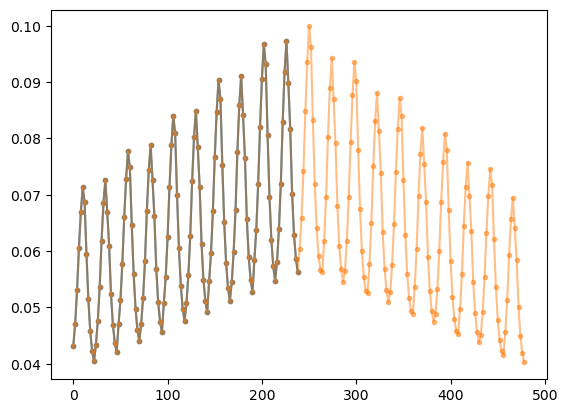

In [178]:
plt.plot(trend1_df.hour, trend1_df['new_ts'], marker='.')
plt.plot(trend2_df.hour, trend2_df['new_ts'], marker='.', alpha=0.5)

In [ ]:
# do 14C results also change with a trend? probably


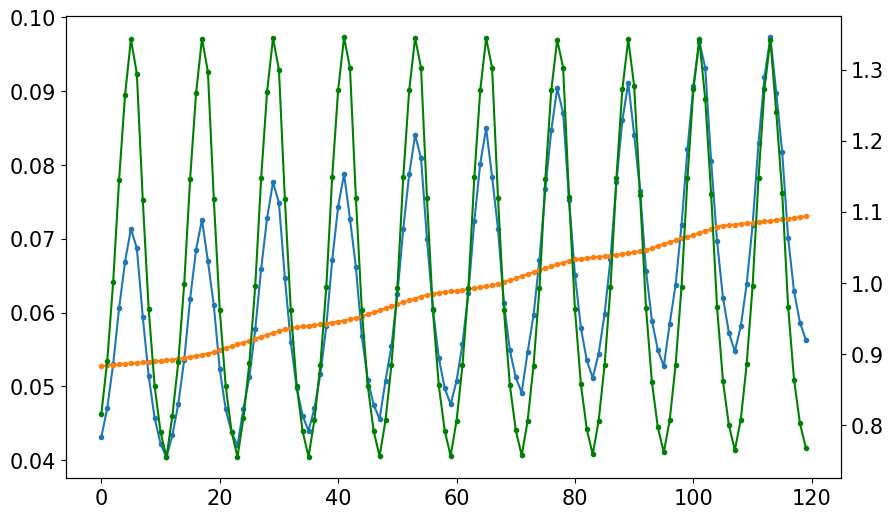

In [216]:



# decompose to get diel and resid of new time series
decomp=run_STL(sim_df, 'new_ts')
# plot results
fig,axs=plt.subplots(figsize=(10,6))
# plot new data
sim_df.new_ts.plot(marker='.')
# plot decomposed trend data
decomp.trend.plot(marker='.')
# plot decomposed diel data
ax0=axs.twinx()
ax0.plot(decomp.diel, marker='.', c='g')

In [230]:
tsd_df=run_STL(sim_df, 'new_ts')
tsd_df['hourly_growth']=exp_growth(tsd_df, 'diel',2).shift(-1)
rates_df=calc_productivity(tsd_df,'hourly_growth','Qc_hour')
mbb_df, mbb_data=run_bootstrapping(rates_df, runs=runs)
# perform bagging on bootstrapped data
bagged=bagging_results(mbb_data)
## return error metrics of day time values
days_only = bagged.loc[bagged['par_mean']>0]
pred=days_only.productivity_mean[:-1]
actual=days_only.NPP_mean[:-1]
rmse, smape, mase=error_metrics(pred, actual)

In [233]:
rmse

0.0014456137653686277

## Interpreting Error Metrics
- RMSE
    - Good for comparing relative errors across models (want to minimize this)
- sMAPE (symetric mean absolute percent error)
    - good [reference](https://medium.com/@davide.sarra/how-to-interpret-smape-just-like-mape-bf799ba03bdc)
    - still not sure whether to scale from 0-100 or 0-200
    - BAD for values close to 0, should probably normalize values first
- WMAPE (weighted mean absolute percent error(
    - mitigates large errors for values close to 0
    - [reference](https://medium.com/@vinitkothari.24/time-series-evaluation-metrics-mape-vs-wmape-vs-smape-which-one-to-use-why-and-when-part1-32d3852b4779)
- MASE (mean absolute scaled error)
    - needs to be scaled to another model (seasonal naive, data point at season back)
    - [explanation](https://help.anaplan.com/advanced-metrics--15d0d0c4-b374-497b-aae9-e42138a13c2f#mase)
    - [more details](https://medium.com/@ashishdce/mean-absolute-scaled-error-mase-in-forecasting-8f3aecc21968)
    
    

Do I care about absolute error (ie how far off the prediction is from the actual result?) Or is relative error more importatn?
- perhaps RMSE and MASE is good, and sMAPE is not required (could consider WMAPE)

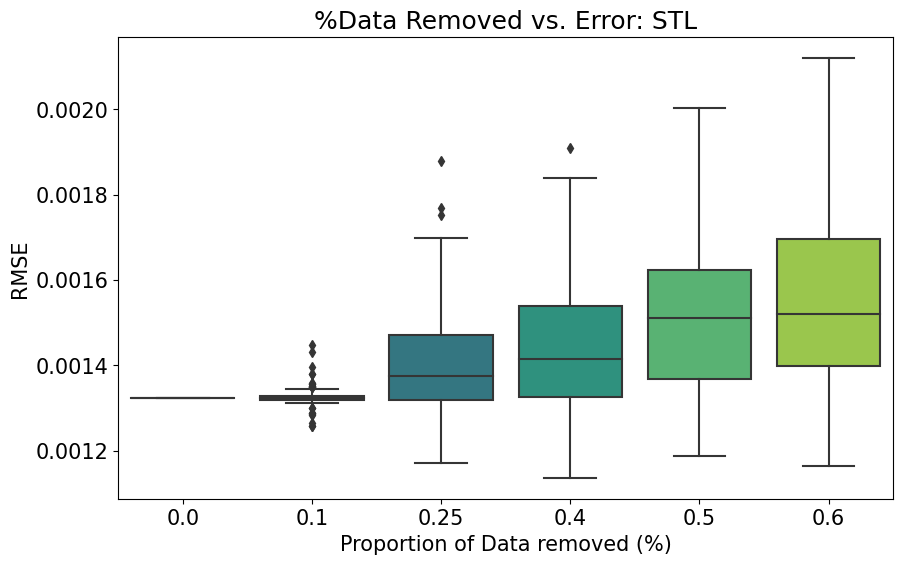

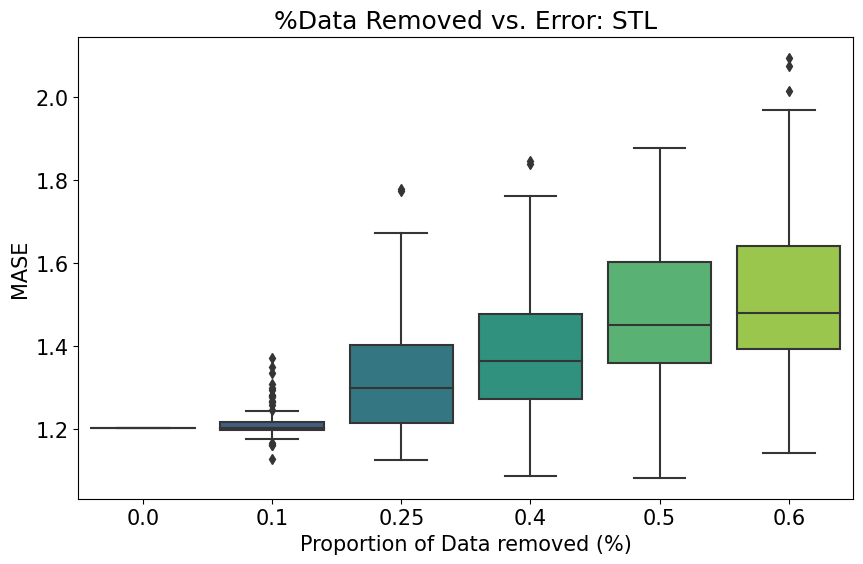

In [49]:
stl_rmse=pd.read_pickle('simulation_data/stl_rmse_df')
stl_mase=pd.read_pickle('simulation_data/stl_mase_df')

error_boxplot(stl_rmse, 'RMSE', 'STL')
error_boxplot(stl_mase, 'MASE', 'STL')

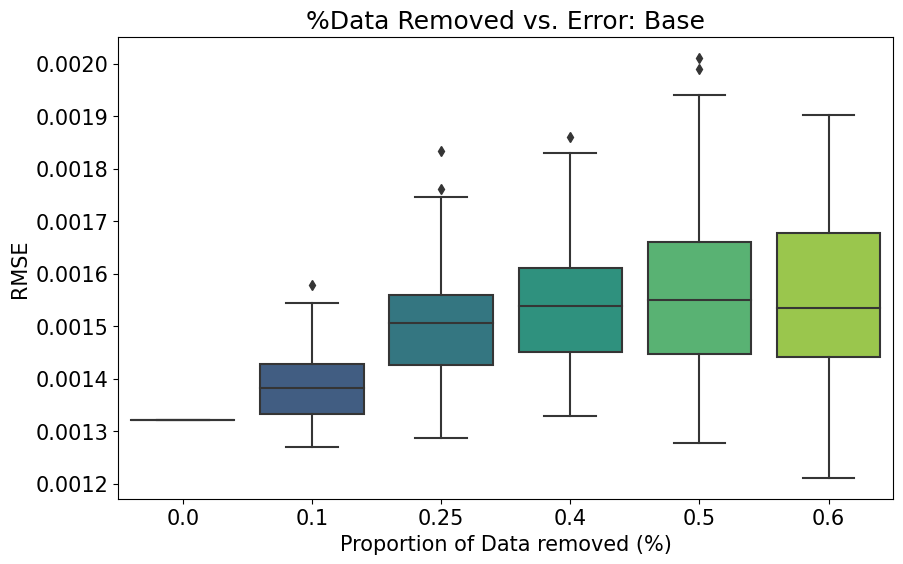

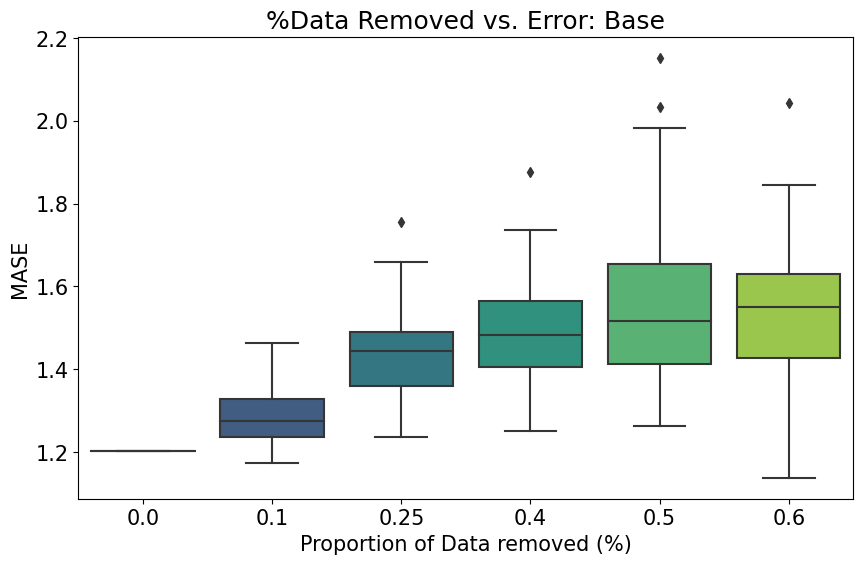

In [22]:
# plot error 
error_boxplot(base_rmse_df, 'RMSE', 'Base')
error_boxplot(base_mase_df, 'MASE', 'Base')

In [74]:
# read in all mase dfs
base_mase=pd.read_pickle('simulation_data/baseline_mase_df')
naive_mase=pd.read_pickle('simulation_data/naive_mase_df')
roll_mase=pd.read_pickle('simulation_data/rolling_mase_df')
stl_mase=pd.read_pickle('simulation_data/stl_mase_df')

# rename inconsistent column names
roll_mase.rename(columns={'mase':'MASE'},inplace=True)
stl_mase.rename(columns={'mase':'MASE'},inplace=True)

## try plotting errors in a line plot
mases=[base_mase, naive_mase, roll_mase, stl_mase]
names=['Baseline','Naive','Rolling','STL']

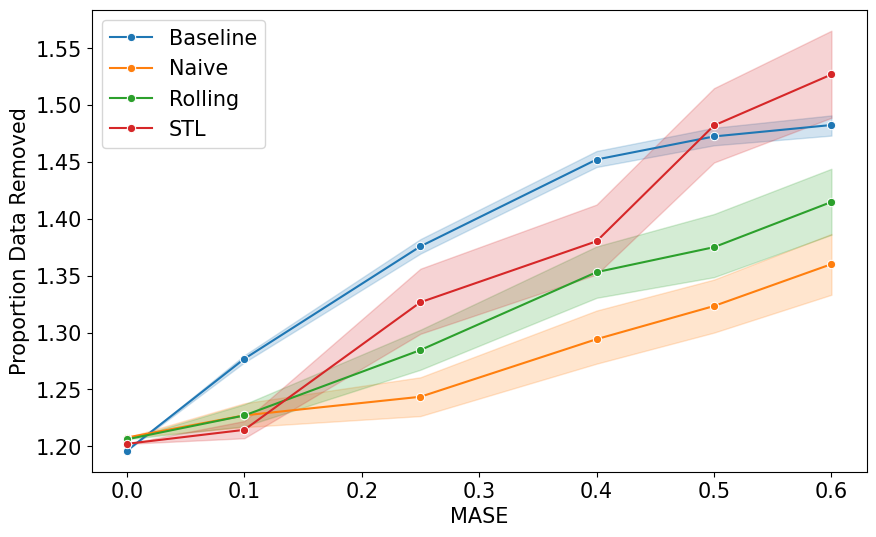

In [76]:
plt.figure(figsize=(10,6))
for model,name in zip(mases,names):
    # add plot to line
    sns.lineplot(x = "removed",
                 y = "MASE",
                 data = model,
                label=name,marker='o')

# add labels and legend
plt.ylabel('Proportion Data Removed')
plt.xlabel('MASE')
plt.legend()
plt.show()

### Post-hoc procedure for ranking models
- What type of error do I want to minimize and why?

For example, I could use the Hochberg post-hoc method to reduce the number of false positives. This would mean that I would prioritize against incorrectly rejecting the true null hypothesis. I could use the true results (NPP values) as a control and the different models to compare against. The baseline would be Annette's method to calculate NPP. 

In [ ]:
rmse_long=rmse_df.melt(var_name='removed', value_name='rmse')

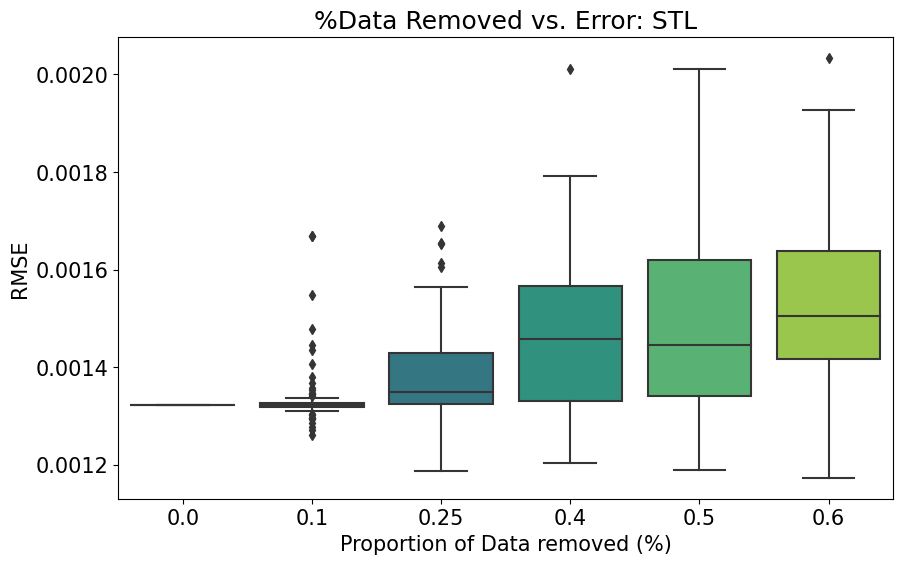

In [18]:
import seaborn as sns

error_long=rmse_df.melt(var_name='removed', value_name='rmse')
fig,axs=plt.subplots(figsize=(10,6))
sns.boxplot(data=error_long, x='removed',y='rmse', palette=sns.color_palette("viridis"))
axs.set_xlabel('Proportion of Data removed (%)')
axs.set_ylabel('RMSE')
axs.set_title('%Data Removed vs. Error: STL')
plt.show()

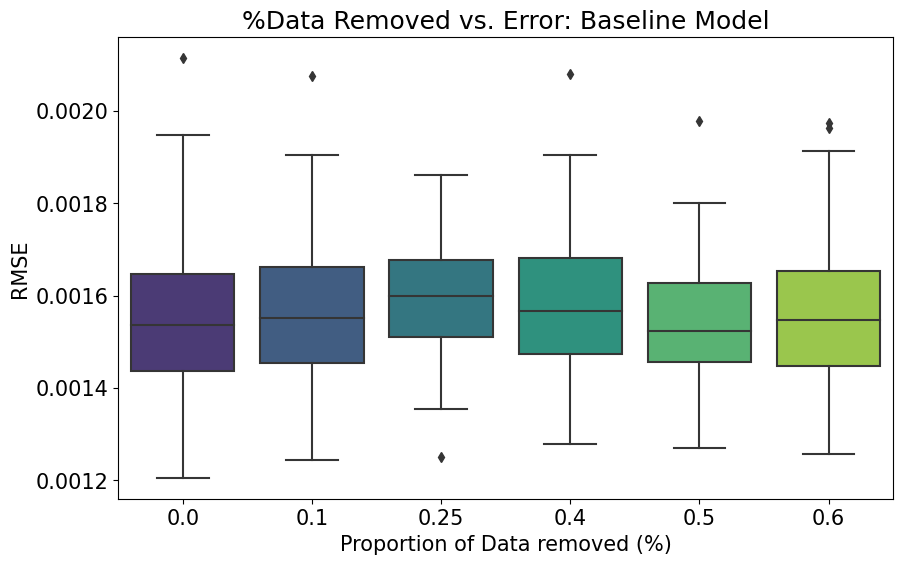

In [16]:
#### For baseline model
bs_rmse_df=pd.DataFrame(rmse_dist)
bs_rmse_df.columns = to_remove
bs_rmse_df.to_pickle('simulation_data/bs_rmse_df')

error_long=bs_rmse_df.melt(var_name='removed', value_name='rmse')
fig,axs=plt.subplots(figsize=(10,6))
sns.boxplot(data=error_long, x='removed',y='rmse', palette=sns.color_palette("viridis"))
axs.set_xlabel('Proportion of Data removed (%)')
axs.set_ylabel('RMSE')
axs.set_title('%Data Removed vs. Error: Baseline Model')
plt.show()

### CONSTRUCTION ZONE BEYOND THIS CELL###
![construction sign](https://media.istockphoto.com/id/1423867660/vector/traffic-road-barrier-road-closed-warning-barrier-flat-vector-illustrations-for-website-under.jpg?s=1024x1024&w=is&k=20&c=xXqtDUeaaaFlqN4cFyvv6rBLyzpuZF89cEKbus2Rw-M=)

### Perform time series train-test split and blocked cross validation (jk i don't think this works)
- Split time series data into training and testing
- Perform k-fold cross validation on varying blocks

**References**
- TS CV [blog post](https://goldinlocks.github.io/Time-Series-Cross-Validation/)
- Netpune AI [tutorial](https://neptune.ai/blog/select-model-for-time-series-prediction-task)
- Medium [blog post ](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)

In [ ]:
# helper function to 
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
#     # Plot the data classes and groups at the end
#     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
#                c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) #+ ['class']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.1], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [45]:
# code from reference listed above
## class to define blocked split for training and testing data for time series CV
class BlockingTimeSeriesSplit():
    # initialize object
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    # class function to return # splits
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    # function to create blocked splits by works by adding margins at two positions. The first is between the 
    # training and validation folds in order to prevent the model from observing lag values which are used twice, 
    # once as an estimator (regressor) and another as a response. The second is between the folds used at 
    # each iteration in order to prevent the model from memorizing patterns from one iteration to the next.
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        # get size of each split
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        # split evenly between training and testing
        margin = 0
        # get indices of data for each split 
        for i in range(self.n_splits):
            # set beginning and end of split
            start = i * k_fold_size
            stop = start + k_fold_size
            # get middle of split to start testing
            mid = int(0.5 * (stop - start)) + start
            # pause function to return splits for training and testing
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# visualize split for normal time series split and blocking
cvs = [TimeSeriesSplit, BlockingTimeSeriesSplit]

for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_cv_indices(this_cv, X, y, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
            ['Testing set', 'Training set'], loc=(1.02, .8))
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
        
plt.show()

In [37]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
# create time series split object
tscv = TimeSeriesSplit(n_splits = 4)
# set error metrics
rmse = []
# run grab training indices from truth data
NPP_truth=tsd_df.NPP.values
# for train_index, test_index in tscv.split(cross_validation):
#     cv_train, cv_test = cross_validation.iloc[train_index], cross_validation.iloc[test_index]
    
#     arma = sm.tsa.ARMA(cv_train, (2,2)).fit(disp=False)
    
#     predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
#     true_values = cv_test.values
#     rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    
# print("RMSE: {}".format(np.mean(rmse)))

In [43]:
counter=0
for train_index, test_index in tscv.split(NPP_truth):
    print(counter)
    print(f'train: {train_index}')
    print(f'test: {test_index}')
    counter+=1

0
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
test: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
1
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
test: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
2
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
test: [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
3
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 